In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn  as sns

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import utils

In [30]:
color_pal = sns.color_palette()

## Reading in files and indexing them on time

In [31]:
Y_train_a = pd.read_parquet('../data/A/train_targets.parquet')
Y_train_b = pd.read_parquet('../data/B/train_targets.parquet')
Y_train_c = pd.read_parquet('../data/C/train_targets.parquet')
Y_train_a = Y_train_a.set_index('time')
Y_train_b = Y_train_b.set_index("time")
Y_train_c = Y_train_c.set_index("time")


In [32]:
X_train_estimated_a = pd.read_parquet('../data/A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('../data/B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('../data/C/X_train_estimated.parquet')
X_train_estimated_a = X_train_estimated_a.set_index("date_forecast")
X_train_estimated_b = X_train_estimated_b.set_index("date_forecast")
X_train_estimated_c = X_train_estimated_c.set_index("date_forecast")


In [33]:
X_train_observed_a = pd.read_parquet('../data/A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('../data/B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('../data/C/X_train_observed.parquet')
X_train_observed_a = X_train_observed_a.set_index("date_forecast")
X_train_observed_b = X_train_observed_b.set_index("date_forecast")
X_train_observed_c = X_train_observed_c.set_index("date_forecast")


In [34]:
X_test_estimated_a = pd.read_parquet('../data/A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('../data/B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('../data/C/X_test_estimated.parquet')
X_test_estimated_a = X_test_estimated_a.set_index("date_forecast")
X_test_estimated_b = X_test_estimated_b.set_index("date_forecast")
X_test_estimated_c = X_test_estimated_c.set_index("date_forecast")


## Some EDA

In [35]:
X_train_observed_a.describe()

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,...,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms
count,118669.000000,118669.000000,96422.000000,1.186690e+05,118669.000000,110603.000000,118669.000000,118669.000000,118669.000000,1.186690e+05,...,118669.000000,118669.000000,118669.000000,118669.000000,118669.000000,118669.000000,118669.000000,118669.000000,118669.000000,118669.000000
mean,6.652576,1.249064,2907.949219,5.994018e+05,166.500381,1737.142212,0.022398,276.823395,44.918282,1.617057e+05,...,179.629486,1.529545,0.059087,280.708557,74.401077,32446.992188,3.043197,0.756781,0.517437,0.000019
std,2.796349,0.036319,2570.413086,8.795423e+05,244.945358,1815.584106,0.190367,6.701763,64.786697,2.301970e+05,...,103.779366,24.146885,0.109496,6.573763,33.515800,17968.044922,1.779247,2.856113,1.851790,0.001392
min,0.700000,1.145000,27.799999,0.000000e+00,0.000000,27.900000,-1.000000,250.899994,0.000000,0.000000e+00,...,0.002000,-50.004002,0.000000,258.899994,0.000000,154.300003,0.000000,-7.300000,-9.300000,-0.000000
25%,4.400000,1.224000,1102.900024,0.000000e+00,0.000000,590.700012,0.000000,272.100006,0.000000,0.000000e+00,...,88.487999,-15.066000,0.000000,275.899994,54.799999,15592.400391,1.700000,-1.400000,-0.700000,0.000000
50%,6.300000,1.247000,1882.400024,3.574770e+04,8.600000,1162.599976,0.000000,277.200012,4.100000,2.481410e+04,...,179.436996,1.202000,0.000000,280.700012,93.699997,36359.800781,2.700000,0.400000,0.500000,0.000000
75%,8.600000,1.272000,3969.750000,1.037819e+06,288.799988,2079.600098,0.000000,282.000000,76.000000,2.743256e+05,...,270.640991,18.995001,0.100000,285.200012,99.900002,48084.500000,4.100000,2.700000,1.700000,0.000000
max,17.500000,1.427000,12328.500000,3.005720e+06,836.400024,11688.700195,1.000000,293.799988,345.700012,1.205498e+06,...,359.997986,49.999001,1.400000,303.299988,100.000000,71349.898438,15.200000,12.300000,8.600000,0.100000


In [36]:
X_train_observed_b.describe()

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,...,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms
count,116929.000000,116929.000000,98157.000000,1.169290e+05,116929.000000,109456.000000,116929.000000,116929.000000,116929.000000,1.169290e+05,...,116929.000000,116929.000000,116929.000000,116929.000000,116929.000000,116929.000000,116929.000000,116929.000000,116929.000000,116929.000000
mean,6.125604,1.254262,2651.450439,5.421514e+05,150.597580,1731.706665,0.008484,275.524536,40.894447,1.472200e+05,...,179.569458,-0.322831,0.059315,279.630524,73.500275,33040.113281,3.122094,0.750841,0.548524,0.000027
std,2.727944,0.035289,2404.853516,8.400522e+05,233.948273,1726.011108,0.117327,6.773766,61.530506,2.187106e+05,...,103.222916,24.058186,0.110211,6.634622,33.893852,18019.267578,1.827768,2.946939,1.881538,0.001654
min,0.700000,1.151000,27.799999,0.000000e+00,0.000000,27.900000,-1.000000,250.899994,0.000000,0.000000e+00,...,0.002000,-50.004002,0.000000,258.899994,0.000000,169.199997,0.000000,-7.300000,-9.300000,0.000000
25%,4.100000,1.230000,1037.900024,0.000000e+00,0.000000,648.799988,0.000000,271.100006,0.000000,0.000000e+00,...,89.507004,-17.388000,0.000000,275.000000,52.700001,16502.699219,1.700000,-1.500000,-0.700000,0.000000
50%,5.500000,1.254000,1732.300049,1.271020e+04,0.000000,1219.800049,0.000000,275.299988,0.000000,1.398140e+04,...,179.457001,-0.276000,0.000000,278.799988,92.599998,37614.101562,2.800000,0.400000,0.600000,0.000000
75%,8.000000,1.277000,3412.199951,8.693612e+05,242.000000,2074.100098,0.000000,280.799988,69.000000,2.484388e+05,...,269.739014,16.606001,0.100000,284.200012,99.900002,48268.601562,4.200000,2.700000,1.700000,0.000000
max,17.500000,1.426000,12328.799805,3.005700e+06,836.400024,11688.900391,1.000000,293.799988,345.700012,1.205341e+06,...,359.998993,49.998001,1.400000,303.299988,100.000000,70618.898438,15.200000,12.400000,8.600000,0.100000


In [37]:
X_train_observed_c.describe()

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,...,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms
count,116825.000000,116825.000000,96902.000000,1.168250e+05,116825.000000,108313.000000,116825.000000,116825.000000,116825.000000,1.168250e+05,...,116825.000000,116825.000000,116825.000000,116825.000000,116825.000000,116825.000000,116825.000000,116825.000000,116825.000000,116825.000000
mean,6.013866,1.253214,2605.747559,5.423583e+05,150.655075,1710.178467,-0.013867,275.147400,40.920612,1.473144e+05,...,179.576492,-0.334226,0.062269,279.682556,73.351135,33186.710938,2.855492,0.739988,0.838296,0.000211
std,2.789840,0.038392,2415.117920,8.404843e+05,234.069214,1751.569336,0.369077,7.103381,61.696342,2.192759e+05,...,103.210327,24.077934,0.114863,6.675199,34.580784,18169.167969,1.632607,2.418446,1.928824,0.011781
min,0.500000,1.139000,27.799999,0.000000e+00,0.000000,27.900000,-1.000000,247.300003,0.000000,0.000000e+00,...,0.003000,-50.042000,0.000000,257.899994,0.000000,130.600006,0.000000,-6.300000,-8.800000,-0.100000
25%,4.000000,1.228000,981.400024,0.000000e+00,0.000000,618.500000,0.000000,270.600006,0.000000,0.000000e+00,...,89.529999,-17.424999,0.000000,275.000000,52.599998,16388.000000,1.600000,-0.900000,-0.500000,0.000000
50%,5.400000,1.253000,1643.000000,1.267980e+04,0.000000,1178.400024,0.000000,274.899994,0.000000,1.394200e+04,...,179.462997,-0.288000,0.000000,278.899994,93.300003,37765.199219,2.500000,0.400000,0.900000,0.000000
75%,7.900000,1.277000,3406.175049,8.698632e+05,242.000000,2056.399902,0.000000,280.600006,68.900002,2.478511e+05,...,269.747009,16.603001,0.100000,284.299988,99.900002,48576.000000,3.800000,2.300000,2.000000,0.000000
max,18.900000,1.441000,12431.299805,3.007722e+06,837.000000,11665.700195,1.000000,295.100006,344.500000,1.217465e+06,...,359.998993,50.036999,1.400000,303.200012,100.000000,72215.000000,14.300000,11.400000,9.000000,0.100000


In [38]:
column_list = X_train_estimated_a.columns.to_list()
for column in column_list:
    print(column)

date_calc
absolute_humidity_2m:gm3
air_density_2m:kgm3
ceiling_height_agl:m
clear_sky_energy_1h:J
clear_sky_rad:W
cloud_base_agl:m
dew_or_rime:idx
dew_point_2m:K
diffuse_rad:W
diffuse_rad_1h:J
direct_rad:W
direct_rad_1h:J
effective_cloud_cover:p
elevation:m
fresh_snow_12h:cm
fresh_snow_1h:cm
fresh_snow_24h:cm
fresh_snow_3h:cm
fresh_snow_6h:cm
is_day:idx
is_in_shadow:idx
msl_pressure:hPa
precip_5min:mm
precip_type_5min:idx
pressure_100m:hPa
pressure_50m:hPa
prob_rime:p
rain_water:kgm2
relative_humidity_1000hPa:p
sfc_pressure:hPa
snow_density:kgm3
snow_depth:cm
snow_drift:idx
snow_melt_10min:mm
snow_water:kgm2
sun_azimuth:d
sun_elevation:d
super_cooled_liquid_water:kgm2
t_1000hPa:K
total_cloud_cover:p
visibility:m
wind_speed_10m:ms
wind_speed_u_10m:ms
wind_speed_v_10m:ms
wind_speed_w_1000hPa:ms


In [39]:
# Notice that missing rows are simply non-existent, not filled with NaN or anything
# From 21. october
display(Y_train_a[29660:29670])

,pv_measurement
time,
2022-10-20 18:00:00,0.0
2022-10-20 19:00:00,0.0
2022-10-20 20:00:00,0.0
2022-10-20 21:00:00,0.0
2022-10-20 22:00:00,0.0
2022-10-20 23:00:00,0.0
2022-10-21 00:00:00,0.0
2022-10-28 22:00:00,0.0
2022-10-28 23:00:00,0.0


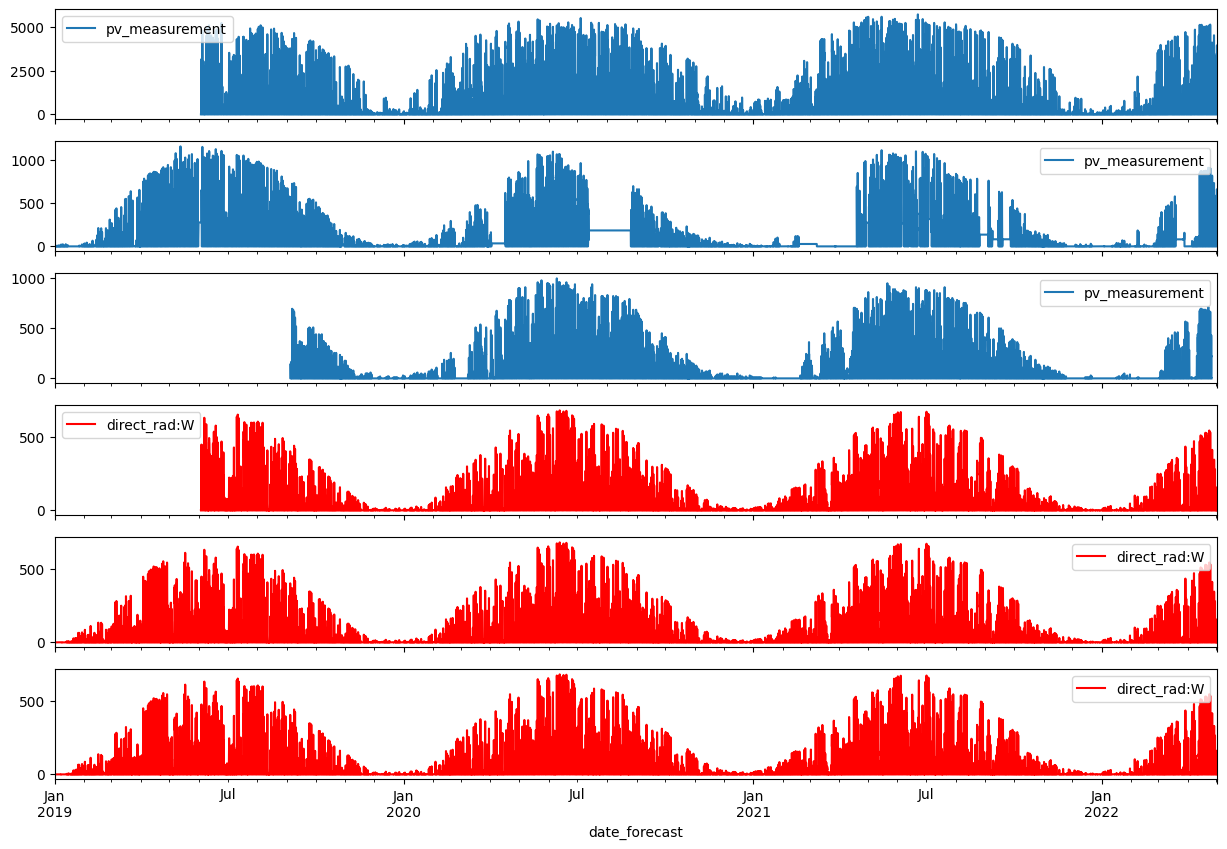

In [40]:
# generalized plotting
start_date = '2019'
end_date = '2024'

feature_name = "direct_rad:W"

Y = [Y_train_a, Y_train_b, Y_train_c]
X = [X_train_observed_a, X_train_observed_b, X_train_observed_c, ]
     # X_train_estimated_a, X_train_estimated_b, X_train_estimated_c, 
     # X_test_estimated_a, X_test_estimated_b, X_test_estimated_c]

utils.plot_ts(y=Y, 
              x=X, 
              feature=feature_name, 
              start=start_date, 
              end=end_date, 
              shareX=True)



## Data Preprocessing

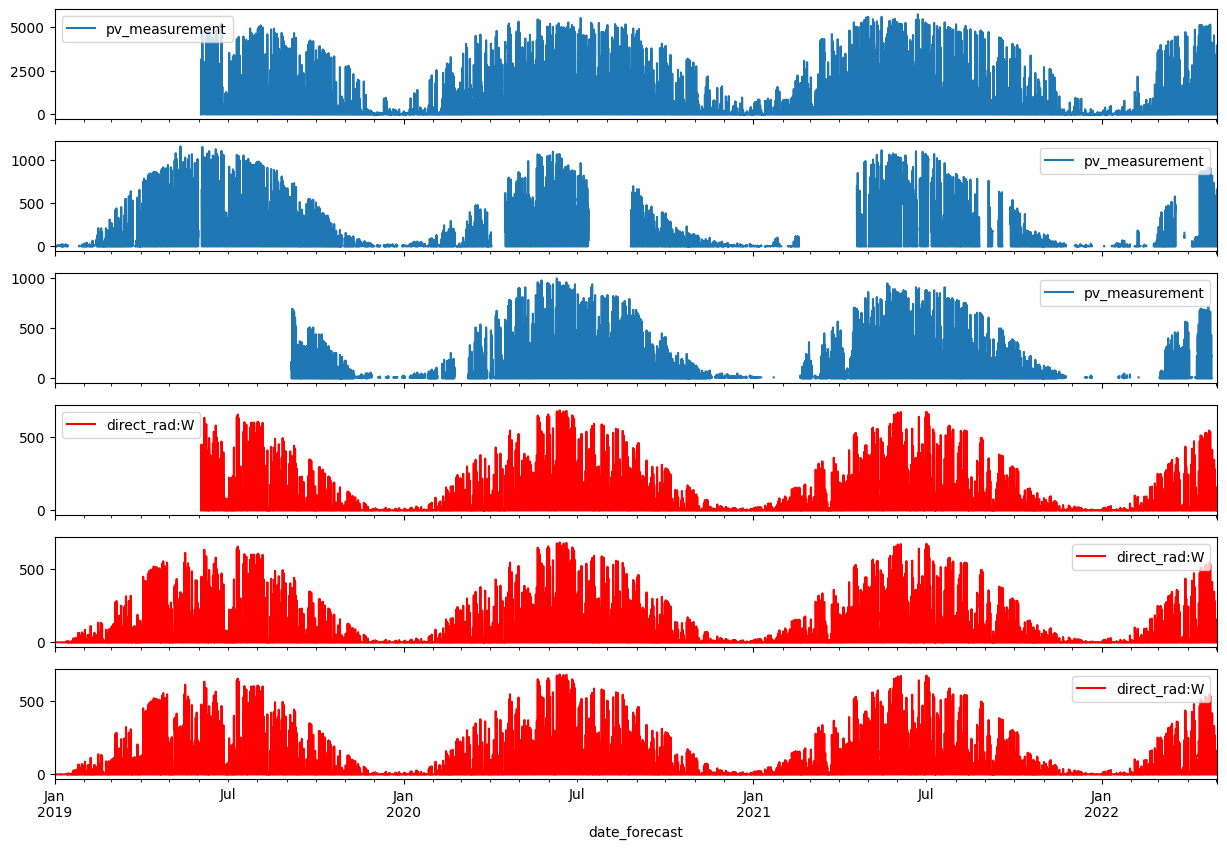

In [41]:
# removing rows where pv_measurment remains the same for more than 18 hours.
Y_train_a_copy = utils.remove_constant_values(Y_train_a, "pv_measurement", 18).dropna()
Y_train_b_copy = utils.remove_constant_values(Y_train_b, "pv_measurement", 18).dropna()
Y_train_c_copy = utils.remove_constant_values(Y_train_c, "pv_measurement", 18).dropna()

Y = [Y_train_a_copy, Y_train_b_copy, Y_train_c_copy]
X = [X_train_observed_a, X_train_observed_b, X_train_observed_c, ]
     # X_train_estimated_a, X_train_estimated_b, X_train_estimated_c, 
     # X_test_estimated_a, X_test_estimated_b, X_test_estimated_c]

start_date = '2019'
end_date = '2023'

utils.plot_ts(y=Y, 
              x=X, 
              feature=feature_name, 
              start=start_date, 
              end=end_date, 
              shareX=True)

### Aggregating to hourly (performed worse than not doing it)

In [42]:
# # Averaging X dataframes to hours, so that it corresponds to y-values
# X_train_estimated_a_copy = utils.quarter_to_hour(X_train_estimated_a)
# X_train_estimated_b_copy = utils.quarter_to_hour(X_train_estimated_b)
# X_train_estimated_c_copy = utils.quarter_to_hour(X_train_estimated_c)
   
# # Join the y values into x-dataframes for training
# train_a = pd.merge(X_train_estimated_a_copy, Y_train_a, left_index=True, right_index=True)
# train_b = pd.merge(X_train_estimated_b_copy, Y_train_b, left_index=True, right_index=True)
# train_c = pd.merge(X_train_estimated_c_copy, Y_train_c, left_index=True, right_index=True)


### Just using the X values for every whole hour

#### Weather forecast

In [43]:
# # add hour and dayofyear as features to the datasets
# X_train_estimated_a_copy = utils.create_features(X_train_estimated_a)
# X_train_estimated_b_copy = utils.create_features(X_train_estimated_b)
# X_train_estimated_c_copy = utils.create_features(X_train_estimated_c)

# # Join the y values into x-dataframes for training
# train_a = pd.merge(X_train_estimated_a_copy, Y_train_a, left_index=True, right_index=True)
# train_b = pd.merge(X_train_estimated_b_copy, Y_train_b, left_index=True, right_index=True)
# train_c = pd.merge(X_train_estimated_c_copy, Y_train_c, left_index=True, right_index=True)

# # get the best features
# correlations = train_a.corrwith(train_a["pv_measurement"])
# for index, corr in correlations.items():
#     correlations[index] = abs(corr)

# sorted = correlations.sort_values(ascending=False)
# best_features = list(sorted[1:10].index)
# print(best_features)


#### Observed Weather

In [50]:
# add hour and dayofyear as features to the datasets
X_train_observed_a_copy = utils.create_features(X_train_observed_a)
X_train_observed_b_copy = utils.create_features(X_train_observed_b)
X_train_observed_c_copy = utils.create_features(X_train_observed_c)

# Join the y values into x-dataframes for training
train_a = pd.merge(X_train_observed_a, Y_train_a_copy, left_index=True, right_index=True)
train_b = pd.merge(X_train_observed_b, Y_train_b_copy, left_index=True, right_index=True)
train_c = pd.merge(X_train_observed_c, Y_train_c_copy, left_index=True, right_index=True)

# get the best features
correlations = train_a.corrwith(train_a["pv_measurement"])
for index, corr in correlations.items():
    correlations[index] = abs(corr)

sorted = correlations.sort_values(ascending=False)
best_features = list(sorted[1:10].index)
print(best_features)

['direct_rad:W', 'direct_rad_1h:J', 'clear_sky_rad:W', 'clear_sky_energy_1h:J', 'diffuse_rad:W', 'sun_elevation:d', 'diffuse_rad_1h:J', 'is_in_shadow:idx', 'is_day:idx']


c:\Users\elias\tdt4173\venv\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\elias\tdt4173\venv\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


## Create our model

In [51]:

### Feature selection
# best_features.append("hour")
# best_features.append("dayofyear")
FEATURES = train_a.columns[1:-1]
# FEATURES = best_features
TARGETS = "pv_measurement"

### DATA
X_a = train_a[FEATURES]
y_a = train_a[TARGETS]
X_b = train_b[FEATURES]
y_b = train_b[TARGETS]
X_c = train_c[FEATURES]
y_c = train_c[TARGETS]



### Location A

In [52]:
### Location A

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_a, y_a, test_size=0.2, random_state=42)

# Create an XGBoostRegressor with some default hyperparameters
reg_A = xgb.XGBRegressor(
    n_estimators=1000,  
    early_stopping_rounds=100,
    learning_rate=0.01,
    objective='reg:absoluteerror', 
)

# Fit the model on the training data
reg_A.fit(X_train, y_train,
        eval_set = [(X_train, y_train), (X_test, y_test)],
        verbose=True)

# Make predictions on the test data
y_pred = reg_A.predict(X_test)

y_pred = np.clip(y_pred, a_min=0, a_max=None)

# check if stuff makes sense
for pred in y_pred[:5]:
    print(pred)
for actual in y_test[:5]:
    print(actual)


# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")

[0]	validation_0-mae:712.14992	validation_1-mae:715.16240
[1]	validation_0-mae:706.82613	validation_1-mae:709.93295
[2]	validation_0-mae:701.54803	validation_1-mae:704.73889
[3]	validation_0-mae:695.97044	validation_1-mae:699.28752
[4]	validation_0-mae:690.70450	validation_1-mae:694.09963
[5]	validation_0-mae:685.02681	validation_1-mae:688.47607


c:\Users\elias\tdt4173\venv\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\elias\tdt4173\venv\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\elias\tdt4173\venv\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\elias\tdt4173\venv\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dt

[6]	validation_0-mae:679.41767	validation_1-mae:682.89012
[7]	validation_0-mae:673.60794	validation_1-mae:677.13723
[8]	validation_0-mae:667.96012	validation_1-mae:671.56396
[9]	validation_0-mae:662.09571	validation_1-mae:665.72226
[10]	validation_0-mae:656.44162	validation_1-mae:660.14153
[11]	validation_0-mae:651.34743	validation_1-mae:655.18873
[12]	validation_0-mae:645.73036	validation_1-mae:649.70161
[13]	validation_0-mae:640.59685	validation_1-mae:644.68669
[14]	validation_0-mae:635.28404	validation_1-mae:639.41167
[15]	validation_0-mae:629.94781	validation_1-mae:634.14467
[16]	validation_0-mae:624.51858	validation_1-mae:628.75184
[17]	validation_0-mae:619.13750	validation_1-mae:623.35902
[18]	validation_0-mae:613.90604	validation_1-mae:618.20837
[19]	validation_0-mae:608.59766	validation_1-mae:612.96787
[20]	validation_0-mae:603.37293	validation_1-mae:607.80602
[21]	validation_0-mae:598.14431	validation_1-mae:602.58278
[22]	validation_0-mae:593.06259	validation_1-mae:597.54006
[

c:\Users\elias\tdt4173\venv\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\elias\tdt4173\venv\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\elias\tdt4173\venv\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\elias\tdt4173\venv\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dt

### Location B

In [53]:
### Location B

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_b, y_b, test_size=0.2, random_state=42)

# Create an XGBoostRegressor with some default hyperparameters
reg_B = xgb.XGBRegressor(
    n_estimators=1000,  
    early_stopping_rounds=100,
    learning_rate=0.01,
    objective='reg:absoluteerror', 
)

# Fit the model on the training data
reg_B.fit(X_train, y_train,
        eval_set = [(X_train, y_train), (X_test, y_test)],
        verbose=True)

# Make predictions on the test data
y_pred = reg_B.predict(X_test)

y_pred = np.clip(y_pred, a_min=0, a_max=None)

# check if stuff makes sense
for pred in y_pred[:5]:
    print(pred)
for actual in y_test[:5]:
    print(actual)

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")

[0]	validation_0-mae:136.06332	validation_1-mae:134.01466
[1]	validation_0-mae:135.04448	validation_1-mae:132.99928
[2]	validation_0-mae:134.04986	validation_1-mae:132.00982
[3]	validation_0-mae:133.04715	validation_1-mae:131.00207
[4]	validation_0-mae:132.02316	validation_1-mae:129.97546
[5]	validation_0-mae:130.93273	validation_1-mae:128.90018
[6]	validation_0-mae:129.84138	validation_1-mae:127.81862
[7]	validation_0-mae:128.86554	validation_1-mae:126.85445
[8]	validation_0-mae:127.79567	validation_1-mae:125.80123
[9]	validation_0-mae:126.82040	validation_1-mae:124.84046
[10]	validation_0-mae:125.80560	validation_1-mae:123.83494


c:\Users\elias\tdt4173\venv\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\elias\tdt4173\venv\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\elias\tdt4173\venv\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\elias\tdt4173\venv\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dt

[11]	validation_0-mae:124.79440	validation_1-mae:122.83624
[12]	validation_0-mae:123.78227	validation_1-mae:121.85357
[13]	validation_0-mae:122.74865	validation_1-mae:120.83691
[14]	validation_0-mae:121.74656	validation_1-mae:119.84550
[15]	validation_0-mae:120.77856	validation_1-mae:118.89941
[16]	validation_0-mae:119.78273	validation_1-mae:117.93438
[17]	validation_0-mae:118.78091	validation_1-mae:116.95458
[18]	validation_0-mae:117.84635	validation_1-mae:116.04205
[19]	validation_0-mae:116.87034	validation_1-mae:115.10200
[20]	validation_0-mae:115.93301	validation_1-mae:114.20706
[21]	validation_0-mae:114.96475	validation_1-mae:113.28279
[22]	validation_0-mae:114.01373	validation_1-mae:112.36381
[23]	validation_0-mae:113.07438	validation_1-mae:111.46315
[24]	validation_0-mae:112.12701	validation_1-mae:110.55927
[25]	validation_0-mae:111.18444	validation_1-mae:109.65757
[26]	validation_0-mae:110.25411	validation_1-mae:108.77103
[27]	validation_0-mae:109.33611	validation_1-mae:107.900

c:\Users\elias\tdt4173\venv\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\elias\tdt4173\venv\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\elias\tdt4173\venv\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\elias\tdt4173\venv\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dt

### Location C

In [54]:
### Location C

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_c, y_c, test_size=0.2, random_state=42)
# Create an XGBoostRegressor with some default hyperparameters
reg_C = xgb.XGBRegressor(
    n_estimators=1000,  
    early_stopping_rounds=100,
    learning_rate=0.01,
    objective='reg:absoluteerror', 
)

# Fit the model on the training data
reg_C.fit(X_train, y_train,
        eval_set = [(X_train, y_train), (X_test, y_test)],
        verbose=False)

# Make predictions on the test data
y_pred = reg_C.predict(X_test)

y_pred = np.clip(y_pred, a_min=0, a_max=None)

# check if stuff makes sense
for pred in y_pred[:5]:
    print(pred)
for actual in y_test[:5]:
    print(actual)

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")

c:\Users\elias\tdt4173\venv\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\elias\tdt4173\venv\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\elias\tdt4173\venv\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\elias\tdt4173\venv\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dt

0.0008461568
789.5452
117.39697
108.10094
11.485832
0.0
754.6
117.60000000000001
156.8
9.8
Mean Absolute Error: 30.19448797835957


c:\Users\elias\tdt4173\venv\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\elias\tdt4173\venv\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\elias\tdt4173\venv\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\elias\tdt4173\venv\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dt

## Predicting on the actual test set

In [55]:
### Location A
X_a = X_test_estimated_a[FEATURES]
A_pred = reg_A.predict(X_a)
A_pred_hourly = []

# # aggregating to hourly
# for i in range(0, len(A_pred), 4):
#     mean = (A_pred[i] + A_pred[i+1] + A_pred[i+2] + A_pred[i+3])/4
#     A_pred_hourly.append(mean)

# just taking the value every whole hour
for i in range(0, len(A_pred), 4):
    A_pred_hourly.append(A_pred[i])


### Location B
X_b = X_test_estimated_b[FEATURES]
B_pred = reg_B.predict(X_b)
B_pred_hourly = []

# # aggregating to hourly
# for i in range(0, len(B_pred), 4):
#     mean = (B_pred[i] + B_pred[i+1] + B_pred[i+2] + B_pred[i+3])/4
#     B_pred_hourly.append(mean)

# just taking the value every whole hour
for i in range(0, len(B_pred), 4):
    B_pred_hourly.append(B_pred[i])
    
    
### Location C
X_c = X_test_estimated_c[FEATURES]
C_pred = reg_C.predict(X_b)
C_pred_hourly = []

# # aggregating to hourly
# for i in range(0, len(C_pred), 4):
#     mean = (C_pred[i] + C_pred[i+1] + C_pred[i+2] + C_pred[i+3])/4
#     C_pred_hourly.append(mean)   

# just taking the value every whole hour
for i in range(0, len(C_pred), 4):
    C_pred_hourly.append(C_pred[i])  

print(len(A_pred_hourly))
print(len(B_pred_hourly))
print(len(C_pred_hourly))
    

720
720
720


c:\Users\elias\tdt4173\venv\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\elias\tdt4173\venv\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\elias\tdt4173\venv\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\elias\tdt4173\venv\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dt

## Storing the predictions

In [ ]:
predictions = np.concatenate([A_pred_hourly, B_pred_hourly, C_pred_hourly])
ids = range(len(predictions))
df = pd.DataFrame({"id": ids, "prediction": predictions})
df.to_csv("saves/xgboost.csv", index=False)